In [21]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import arviz as az

In [22]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

t_start = 0
dt = 0.001
t_end = 0.5
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

u_0true = np.zeros(n_x)
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

In [23]:
# Observation Parameters
sigma_n_true = 0.005
spatial_points = 15
temporal_points = 10

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

In [24]:
true_alpha = 1
true_beta = 1

@fem.BilinearForm
def a(u,v,w):
    x = w.x
    return u*v

@fem.BilinearForm
def b(u,v,w):
    x = w.x
    return true_alpha*dot(grad(u),grad(v))

@fem.LinearForm
def l(v,w):
    x = w.x
    f = 8 * np.cos(np.pi*8*x[0]) + true_beta
    return (f)*v
    #return (0.)*v

A_mat = a.assemble(basis)
B_mat = b.assemble(basis)
L_vec = l.assemble(basis)

def boundary_function(boundary_coordinate_list):
    return 0.

pre_OP1 = A_mat + dt*B_mat
pre_OP1[boundary_indices, :] = pre_OP1[:, boundary_indices] = 0.
pre_OP1[boundary_indices, boundary_indices] = 1.
OP1 = scsparse.linalg.inv(pre_OP1)

for i, t in enumerate(time_range[:-1]):
    OP2 = dt*L_vec + A_mat @ u_strue[i,:]
    OP2[boundary_indices] = boundary_function(true_coordinates[boundary_indices])
    #u_s[i,boundary_indices] = boundary_function(coordinates[boundary_indices])
    #u_s[i+1,:] = dt*OP1 @ L_vec + OP1 @ A_mat @ u_s[i,:]
    u_strue[i+1,:] = OP1 @ OP2

u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


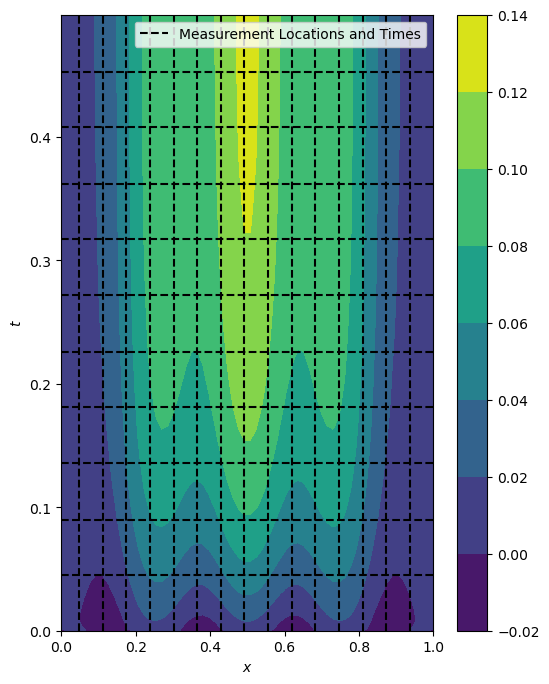

In [91]:
fig, axes = plt.subplots(figsize=(6,8))
plot = axes.contourf(true_coordinates.flatten(), time_range, u_strue)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Locations and Times', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

#axes.scatter(x_temp, y_temp, marker='x', label='Observed Points', color='black')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
fig.colorbar(plot)
plt.legend()
plt.show()

In [26]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

t_start = 0
dt = 0.001
t_end = 0.5
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

u_0 = np.zeros(n_x)
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

covs = []

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [27]:
@fem.BilinearForm
def M_form(u,v,w):
    return u*v

@fem.BilinearForm
def A_form(u,v,w):
    return dot(grad(u),grad(v))

@fem.LinearForm
def L_form(v,w):
    return 1. * v

K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

A_mat = (A_form.assemble(basis)).toarray()
L_vec = L_form.assemble(basis)
M_mat = (M_form.assemble(basis)).toarray()

def left_side(alpha):
    left_mat = (M_mat + (dt*alpha/2)*A_mat)
    left_mat = subtensor.set_subtensor(left_mat[0,:], 0.)
    left_mat = subtensor.set_subtensor(left_mat[-1,:], 0.)
    left_mat = subtensor.set_subtensor(left_mat[0,0], 1.)
    left_mat = subtensor.set_subtensor(left_mat[-1,-1], 1.)
    # left_mat[boundary_indices,:] = left_mat[:,boundary_indices] = 0.
    # left_mat[boundary_indices, boundary_indices] = 1.
    return left_mat

def left_side_np(alpha):
    left_mat = (M_mat + (dt*alpha/2)*A_mat)
    # left_mat = subtensor.set_subtensor(left_mat[0,:], 0.)
    # left_mat = subtensor.set_subtensor(left_mat[-1,:], 0.)
    # left_mat = subtensor.set_subtensor(left_mat[0,0], 1.)
    # left_mat = subtensor.set_subtensor(left_mat[-1,-1], 1.)
    left_mat[boundary_indices,:] = left_mat[:,boundary_indices] = 0.
    left_mat[boundary_indices, boundary_indices] = 1.
    return left_mat

def right_side(alpha, beta, u_prev):
    right_mat = (M_mat - (dt*alpha/2)*A_mat) @ u_prev + dt*beta*L_vec
    right_mat = subtensor.set_subtensor(right_mat[0], 0.)
    right_mat = subtensor.set_subtensor(right_mat[-1], 0.)
    return right_mat

def G_theta_mat(rho, ell):
    G_vec = (rho**2)*tensor.math.exp(K_theta_3/(2*(ell**2)))
    return tensor.reshape(G_vec, (n_x, n_x))

def G_theta_mat_np(rho, ell):
    G_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))


In [29]:
# PRIORS ------------
# alpha
lower = 0.0001
upper = 3.
mu = 1.5
sigma = 0.5
alpha_params = [lower, upper, mu, sigma]

# beta
lower = 0.0001
upper = 3.
mu = 0.5
sigma = 0.5
beta_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.1
sigma = 0.01
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 0.1
sigma = 0.1
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 1.
mu = 0.005
sigma = 0.005
sigma_n_params = [lower, upper, mu, sigma]

# --------------

In [30]:
# Defining Parameters

# alpha = 1.
# beta = 1.
# rho = 0.1
# ell = 0.1
# sigma_n = 0.005

# def from_posterior(param, samples):
#     smin, smax = np.min(samples), np.max(samples)
#     width = smax - smin
#     x = np.linspace(smin, smax, 100)
#     y = scstats.gaussian_kde(samples)(x)

#     # what was never sampled should have a small probability but not 0,
#     # so we'll extend the domain and use linear approximation of density on it
#     x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
#     y = np.concatenate([[0], y, [0]])
#     return pm.Interpolated(param, x, y)

alpha = alpha_params[2]
beta = beta_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

traces = [] # box of traces
priors = [] # box of kdes

data_index = 0 # index of observation vector

for i, t in tqdm(enumerate(time_range[:-1])):
    if i == 0: # if its the first step, we initialise mean based off initial condition, and initialise cov matrix
        right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
        right_hand_side[0] = right_hand_side[-1] = 0.
        pred_mean = np.linalg.inv(left_side_np(alpha)) @ right_hand_side
        pred_cov = dt*np.linalg.inv(left_side_np(alpha)) @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ np.linalg.inv(left_side_np(alpha)).T
        u_s[i+1, :] = pred_mean
        covs.append(pred_cov)
    else: # if it isnt the first step,
        if time_operator[i] == False: # and we dont have data for the current step, update as usual, but since cov matrix isnt evolving we can just duplicate it
            right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
            right_hand_side[0] = right_hand_side[-1] = 0.
            pred_mean = np.linalg.inv(left_side_np(alpha)) @ right_hand_side
            u_s[i+1,:] = pred_mean
            covs.append(covs[-1])
        else: # and we do have data, we MCMC step
            with pm.Model() as model:
                if data_index == 0: # if its the first time that data has come in, we use the initial trunc norm priors
                    alpha = pm.TruncatedNormal('alpha', mu=alpha_params[3], sigma=alpha_params[2], lower=alpha_params[0], upper=alpha_params[1])
                    beta = pm.TruncatedNormal('beta', mu=beta_params[3], sigma=beta_params[2], lower=beta_params[0], upper=beta_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho_params[3], sigma=rho_params[2], lower=rho_params[0], upper=rho_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell_params[3], sigma=ell_params[2], lower=ell_params[0], upper=ell_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[3], sigma=sigma_n_params[2], lower=sigma_n_params[0], upper=sigma_n_params[1])
                else: # otherwise, we use a kde estimate from previous trace
                    # alpha = pm.DensityDist('alpha', logp=custom_alpha_prior)
                    # beta = pm.DensityDist('beta', logp=custom_beta_prior)
                    # rho = pm.DensityDist('rho', logp=custom_rho_prior)
                    # ell = pm.DensityDist('ell', logp=custom_ell_prior)
                    # sigma_n = pm.DensityDist('sigma_n', logp=custom_sigma_n_prior)
                    # alpha = from_posterior('alpha', traces[-1].posterior['alpha'].data.flatten())
                    # beta = from_posterior('beta', traces[-1].posterior['beta'].data.flatten())
                    # rho = from_posterior('rho', traces[-1].posterior['rho'].data.flatten())
                    # ell = from_posterior('ell', traces[-1].posterior['ell'].data.flatten())
                    # sigma_n = from_posterior('sigma_n', traces[-1].posterior['sigma_n'].data.flatten())
                    alpha = pm.TruncatedNormal('alpha', mu=alpha, sigma=alpha_std, lower=alpha_params[0], upper=alpha_params[1])
                    beta = pm.TruncatedNormal('beta', mu=beta, sigma=beta_std, lower=beta_params[0], upper=beta_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_params[0], upper=rho_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_params[0], upper=ell_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_params[0], upper=sigma_n_params[1])
                
                left_side_matrix = pm.Deterministic('left_side', left_side(alpha))
                G_rho_ell = pm.Deterministic('G_rho_ell', M_mat @ G_theta_mat(rho, ell) @ M_mat.T)

                left_side_inv = tensor.nlinalg.matrix_inverse(left_side_matrix)
                right_side_vector = pm.Deterministic('right_side', right_side(alpha, beta, u_s[i,:]))
                mu_u = pm.Deterministic('mu_u', left_side_inv @ right_side_vector)
                cov_u = pm.Deterministic('cov_u', (left_side_inv @ (M_mat - (dt*alpha/2)*A_mat)) @ covs[-1] @ (left_side_inv @ (M_mat - (dt*alpha/2)*A_mat)).T + dt*left_side_inv@ G_rho_ell @ left_side_inv.T)

                cov_chol = tensor.linalg.cholesky(observation_operator @ cov_u @ observation_operator.T + sigma_n**2 * np.eye(spatial_points))
                y_obs = pm.MvNormal('y_obs', mu = observation_operator @ mu_u, chol = cov_chol, observed=u_observed[data_index,:])
                trace = pm.sample(nuts_sampler="numpyro", chains=2, target_accept=0.95)
                traces.append(trace)

            # build kdes of parameters
            # current_alpha_kde = scstats.gaussian_kde(traces[-1].posterior['alpha'].data.flatten())
            # current_beta_kde = scstats.gaussian_kde(traces[-1].posterior['beta'].data.flatten())
            # current_rho_kde = scstats.gaussian_kde(traces[-1].posterior['rho'].data.flatten())
            # current_ell_kde = scstats.gaussian_kde(traces[-1].posterior['ell'].data.flatten())
            # current_sigma_n_kde = scstats.gaussian_kde(traces[-1].posterior['sigma_n'].data.flatten())

            # priors.append([current_alpha_kde, current_beta_kde, current_ell_kde, current_rho_kde, current_sigma_n_kde])

            # def custom_alpha_prior(value):
            #     return current_alpha_kde.logpdf(value)
            
            # def custom_beta_prior(value):
            #     return current_beta_kde.logpdf(value)
            
            # def custom_rho_prior(value):
            #     return current_rho_kde.logpdf(value)
            
            # def custom_ell_prior(value):
            #     return current_ell_kde.logpdf(value)
            
            # def custom_sigma_n_prior(value):
            #     return current_sigma_n_kde.logpdf(value)
            
            # update parameters to means of their posteriors
            alpha = np.mean(traces[-1].posterior['alpha'].data.flatten())
            alpha_std = np.std(traces[-1].posterior['alpha'].data.flatten())
            beta = np.mean(traces[-1].posterior['beta'].data.flatten())
            beta_std = np.std(traces[-1].posterior['beta'].data.flatten())
            rho = np.mean(traces[-1].posterior['rho'].data.flatten())
            rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
            ell = np.mean(traces[-1].posterior['ell'].data.flatten())
            ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
            sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
            sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())

            # compute mean and covariance based off of estimated parameters, and
            right_hand_side = (M_mat - (dt*alpha/2)*A_mat) @ u_s[i,:] + dt*beta*L_vec
            right_hand_side[0] = right_hand_side[-1] = 0.
            pred_mean = np.linalg.inv(left_side_np(alpha)) @ right_hand_side
            pred_cov = (np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat)) @ covs[-1] @ (np.linalg.inv(left_side_np(alpha)) @ (M_mat - (dt*alpha/2)*A_mat)).T + dt*np.linalg.inv(left_side_np(alpha)) @ M_mat @ G_theta_mat_np(rho, ell) @ M_mat.T @ np.linalg.inv(left_side_np(alpha)).T
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ np.linalg.inv(observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)) @ (u_observed[data_index] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ np.linalg.inv(observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)) @ observation_operator @ pred_cov
            u_s[i+1,:] = updated_mean
            covs.append(updated_cov)
            data_index += 1


cov_diags = np.zeros((number_of_steps, number_of_x_axial_cells))
for i in range(number_of_steps-1):
    cov_diags[i,:] = np.diag(covs[i])

0it [00:00, ?it/s]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
46it [01:01,  1.34s/it]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least 4 chains for robust computation of convergence diagnostics
91it [01:48,  1.17s/it]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
We recommend running at least

In [39]:
temporal_measurement_indices

array([ 45,  90, 136, 181, 226, 272, 317, 362, 408, 453])

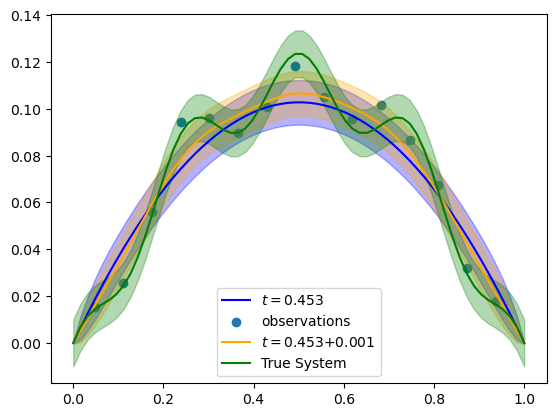

In [96]:
interest = 9
group_labels = [r"$t=$"+str(temporal_measurement_coordinates[i]) for i in range(len(temporal_measurement_coordinates))]
plot_ind = temporal_measurement_indices[interest]
plt.plot(coordinates,u_s[plot_ind,:], label=group_labels[interest], color='blue')
plt.fill_between(coordinates.flatten(), u_s[plot_ind,:] - 2*np.sqrt(cov_diags[plot_ind]), u_s[plot_ind,:] + 2*np.sqrt(cov_diags[plot_ind]), alpha=0.3, color='blue')
plt.scatter(spatial_measurement_coordinates, u_observed[interest,:], label='observations')
plt.plot(coordinates,u_s[plot_ind + 1,:], label=group_labels[interest] + '+' + str(dt),color='orange')
plt.fill_between(coordinates.flatten(), u_s[plot_ind+1,:] - 2*np.sqrt(cov_diags[plot_ind+1]), u_s[plot_ind+1,:] + 2*np.sqrt(cov_diags[plot_ind+1]), alpha=0.3, color='orange')
plt.plot(true_coordinates, u_strue[plot_ind+1,:], label='True System', color='green')
plt.fill_between(true_coordinates.flatten(), u_strue[plot_ind+1,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[plot_ind+1,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), color='green', alpha=0.3)
plt.legend()

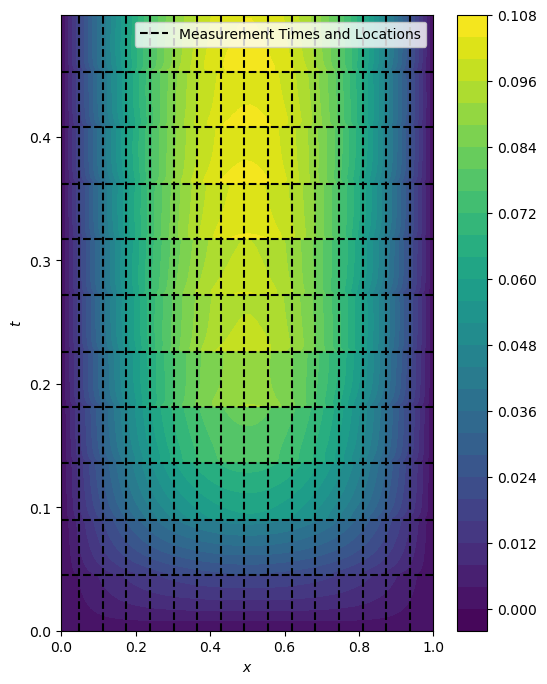

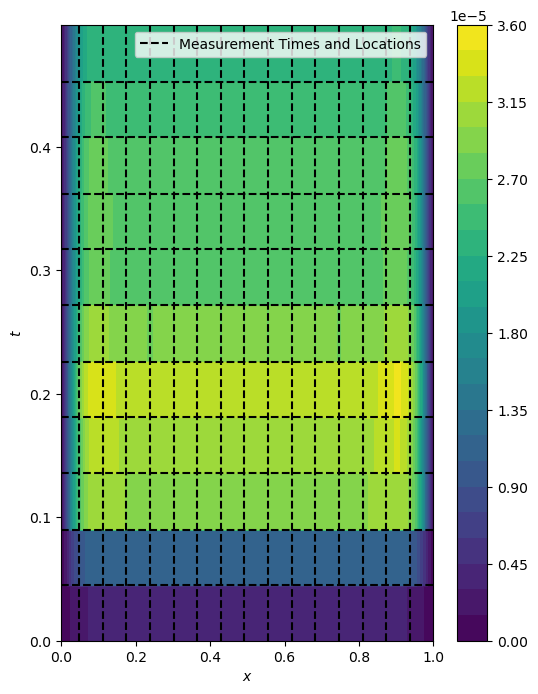

In [45]:
fig, axes = plt.subplots(figsize=(6,8))
plot = axes.contourf(coordinates.flatten(), time_range, u_s, levels=30)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
fig.colorbar(plot)
plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(6,8))
plot = axes.contourf(coordinates.flatten(), time_range, cov_diags, levels=30)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black')
    else:
        axes.axhline(coord, linestyle='--', color='black')
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
fig.colorbar(plot)
plt.legend()
plt.show()

/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

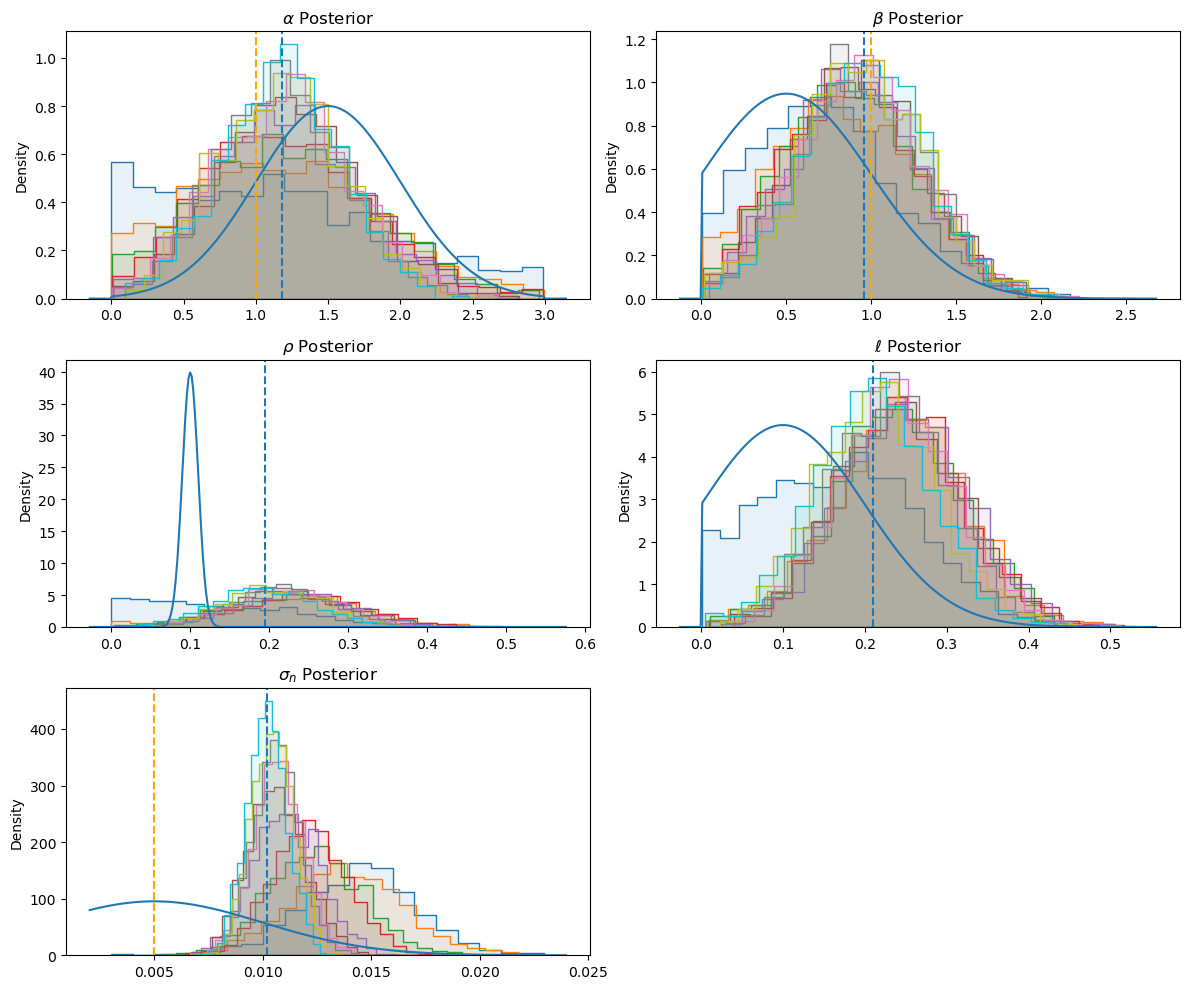

In [50]:
group_labels = [r"$t=$"+str(temporal_measurement_coordinates[i]) for i in range(len(temporal_measurement_coordinates))]

# Plotting histograms
plt.figure(figsize=(12, 10))

bins_num = 20
alpha_val = 0.1

plt.subplot(3, 2, 1)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    else:
        sns.histplot(trace.posterior['alpha'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (alpha_params[0] - alpha_params[2]) / alpha_params[3], (alpha_params[1] - alpha_params[2]) / alpha_params[3]
truncated_normal = truncnorm(a, b, loc=alpha_params[2], scale=alpha_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior')
plt.axvline(true_alpha, color='orange', label='True Value', linestyle='--')
plt.axvline(alpha, label='Final Posterior Mean', linestyle='--')
#plt.legend()
plt.title(r'$\alpha$ Posterior')

plt.subplot(3, 2, 2)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['beta'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    else:
        sns.histplot(trace.posterior['beta'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (beta_params[0] - beta_params[2]) / beta_params[3], (beta_params[1] - beta_params[2]) / beta_params[3]
truncated_normal = truncnorm(a, b, loc=beta_params[2], scale=beta_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior')
plt.axvline(true_beta, color='orange', label='True Value', linestyle='--')
plt.axvline(beta, label='Final Posterior Mean', linestyle='--')
#plt.legend()
plt.title(r'$\beta$ Posterior')

plt.subplot(3, 2, 3)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    else:
        sns.histplot(trace.posterior['rho'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (rho_params[0] - rho_params[2]) / rho_params[3], (rho_params[1] - rho_params[2]) / rho_params[3]
truncated_normal = truncnorm(a, b, loc=rho_params[2], scale=rho_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior')
plt.axvline(rho, label='Final Posterior Mean', linestyle='--')
#plt.legend()
plt.title(r'$\rho$ Posterior')

plt.subplot(3, 2, 4)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    else:
        sns.histplot(trace.posterior['ell'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (ell_params[0] - ell_params[2]) / ell_params[3], (ell_params[1] - ell_params[2]) / ell_params[3]
truncated_normal = truncnorm(a, b, loc=ell_params[2], scale=ell_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior')
plt.axvline(ell, label='Final Posterior Mean', linestyle='--')
#plt.legend()
plt.title(r'$\ell$ Posterior')

plt.subplot(3, 2, 5)
group = 1
for trace in traces:
    if group == 1:
        ax = sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    else:
        sns.histplot(trace.posterior['sigma_n'].data.flatten(), bins=bins_num, stat='density', element='step', label = group_labels[group-1], alpha=alpha_val)
    group += 1
x_left, x_right = ax.get_xlim()
bottom_axis = np.linspace(x_left, x_right, 300)
a, b = (sigma_n_params[0] - sigma_n_params[2]) / sigma_n_params[3], (sigma_n_params[1] - sigma_n_params[2]) / sigma_n_params[3]
truncated_normal = truncnorm(a, b, loc=sigma_n_params[2], scale=sigma_n_params[3])
plt.plot(bottom_axis, truncated_normal.pdf(bottom_axis), label='Initial Prior')
plt.axvline(0.005, color='orange', label='True Value', linestyle='--')
plt.axvline(sigma_n, label='Final Posterior Mean', linestyle='--')
#plt.legend()
plt.title(r'$\sigma_n$ Posterior')

plt.tight_layout()
plt.show()


In [86]:
alpha_estimates = [alpha_params[2]] + [np.mean(traces[i].posterior['alpha'].data.flatten()) for i in range(len(traces))] + [alpha]
beta_estimates = [beta_params[2]] +[np.mean(traces[i].posterior['beta'].data.flatten()) for i in range(len(traces))] + [beta]
rho_estimates = [rho_params[2]] +[np.mean(traces[i].posterior['rho'].data.flatten()) for i in range(len(traces))] + [rho]
ell_estimates = [ell_params[2]] +[np.mean(traces[i].posterior['ell'].data.flatten()) for i in range(len(traces))] + [ell]
sigma_n_estimates = [sigma_n_params[2]] +[np.mean(traces[i].posterior['sigma_n'].data.flatten()) for i in range(len(traces))] + [sigma_n]
rms = np.sqrt(np.mean((u_s - u_strue)**2, axis=1))
plot_time_coords = temporal_measurement_coordinates
plot_time_coords = np.insert(plot_time_coords, 0, 0.)
plot_time_coords = np.append(plot_time_coords, time_range[-1])

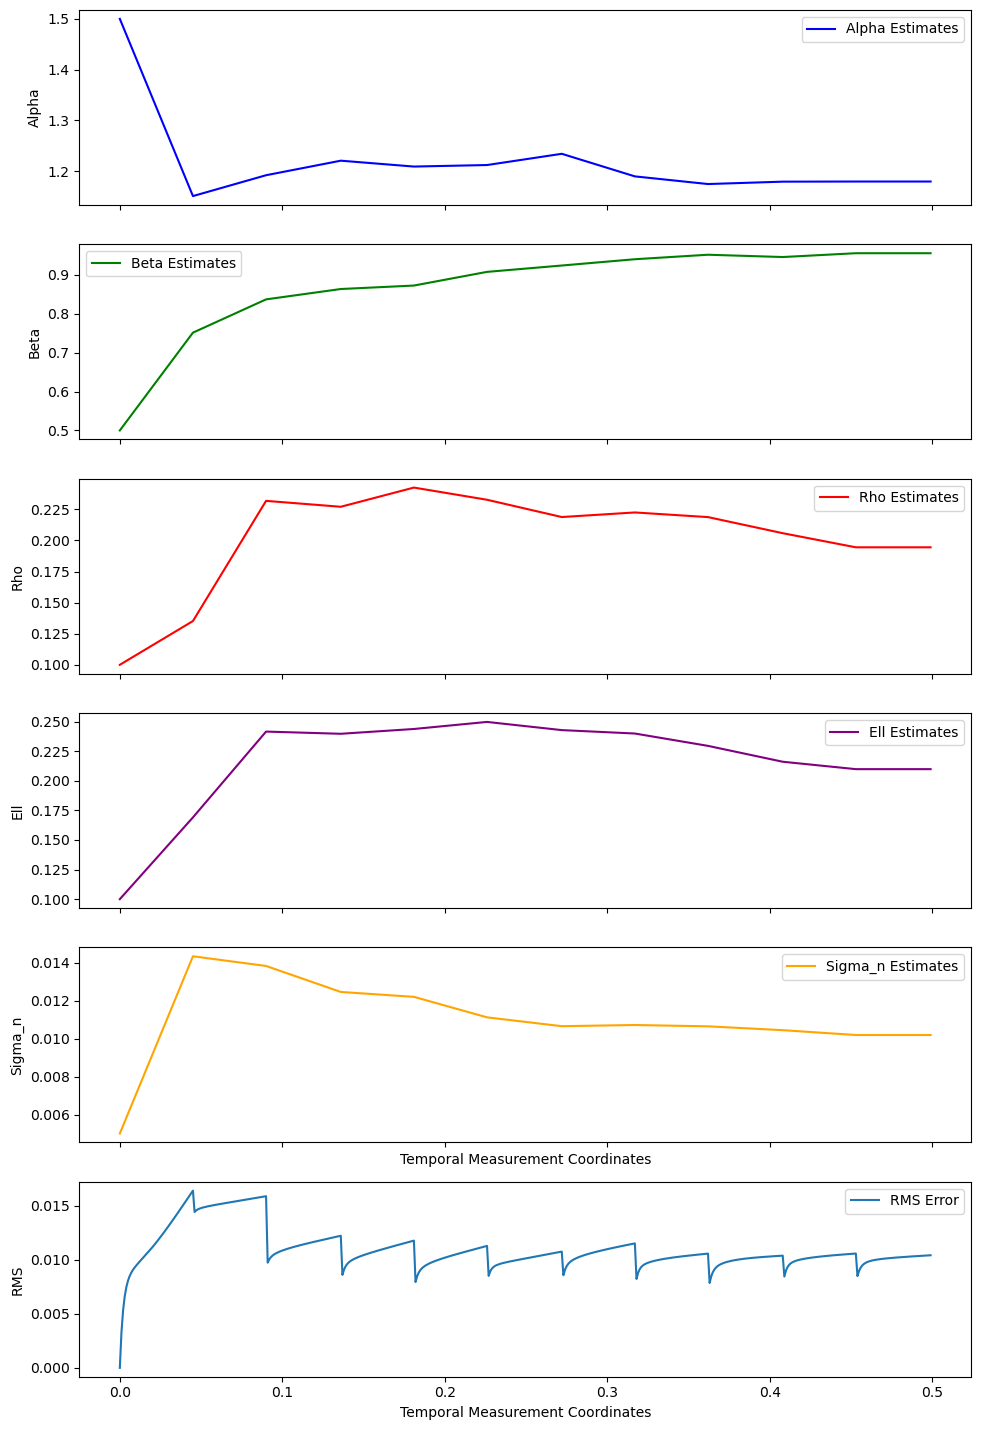

In [87]:
fig, axs = plt.subplots(6, 1, figsize=(10, 15), sharex=True)

# Scatter plots for the first five estimates
axs[0].plot(plot_time_coords, alpha_estimates, label='Alpha Estimates', color='blue')
axs[0].set_ylabel('Alpha')
axs[0].legend()

axs[1].plot(plot_time_coords, beta_estimates, label='Beta Estimates', color='green')
axs[1].set_ylabel('Beta')
axs[1].legend()

axs[2].plot(plot_time_coords, rho_estimates, label='Rho Estimates', color='red')
axs[2].set_ylabel('Rho')
axs[2].legend()

axs[3].plot(plot_time_coords, ell_estimates, label='Ell Estimates', color='purple')
axs[3].set_ylabel('Ell')
axs[3].legend()

axs[4].plot(plot_time_coords, sigma_n_estimates, label='Sigma_n Estimates', color='orange')
axs[4].set_ylabel('Sigma_n')
axs[4].set_xlabel('Temporal Measurement Coordinates')
axs[4].legend()

axs[5].plot(time_range, rms, label='RMS Error')
axs[5].set_ylabel('RMS')
axs[5].set_xlabel('Temporal Measurement Coordinates')
axs[5].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [83]:
time_range[-1]

0.499